# Hopfield Networks 5

More Hopfield network noise resistance tests.

In [3]:
import matplotlib.pyplot as plt
import numpy as np; np.random.seed(0)
from matplotlib.ticker import MaxNLocator

from ann.hopfield_network import HopfieldNetwork, profile_noise_resistance
from ann.plotting import figsize, subplots

# Load Images

In [4]:
pict = np.genfromtxt('../data/pict.dat', delimiter=',', dtype=np.int8).reshape(11, 1024)

# Profile Noise Resistance at different Capacities

In [5]:
def add_noise(pattern, noise):
    pattern_noisy = pattern.copy()
            
    to_flip = np.random.choice(
        len(pattern_noisy), size=noise, replace=False)

    pattern_noisy[to_flip] *= -1
    
    return pattern_noisy

In [9]:
def profile_capacity1(n,
                      patterns=None,
                      random=False,
                      size=None,
                      noise=100,
                      synchronous=True,
                      runs=100,
                      ax=None):
    
    if ax is None:
        _, ax = subplots(1, 1, size=figsize(1, 2))

    if isinstance(n, int):
        n = (1, n)

    if len(n) == 3:
        ns = range(n[0], n[1] + 1, n[2])
    else:
        ns = range(n[0], n[1] + 1)

    if random:
        patterns = [
            np.random.choice([-1, 1], size=size).astype(np.int8)
            for _ in range(n[1] + 1)
        ]

    res = []
    for n_train in ns:
        model = HopfieldNetwork()

        model.train(patterns[:n_train],
                    synchronous=synchronous,
                    check=False)

        correct = 0
        for r in range(runs):
            fmt = "{} patterns ({}/{})"
            sys.stdout.write(fmt.format(n_train, r + 1, runs).ljust(80) + "\r")
            sys.stdout.flush()

            i = np.random.choice(n_train)
            pattern_noisy = add_noise(patterns[i], noise)

            pattern_ = model.recall(pattern_noisy, synchronous=synchronous)

            if np.array_equal(pattern_, patterns[i]):
                correct += 1

        res.append(correct / runs * 100)

    ax.plot(ns, res)

    upd_type = "Synchronous" if synchronous else "Asynchronous"
    ax.set_title("{} Updates, {} Bitflips".format(upd_type, noise))

    ax.set_xlabel("Stored Patterns")
    ax.set_ylabel("Recallable Patterns (Percent)")

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

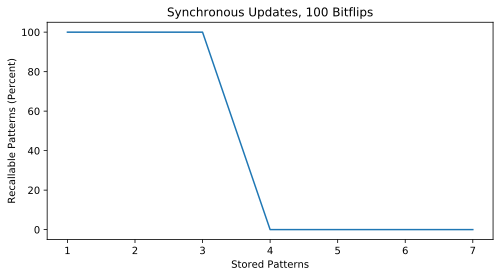

In [11]:
profile_capacity1(n=(1, 7), patterns=[pict[i, :] for i in range(7)])

plt.savefig('../figures/safe_storage.svg')

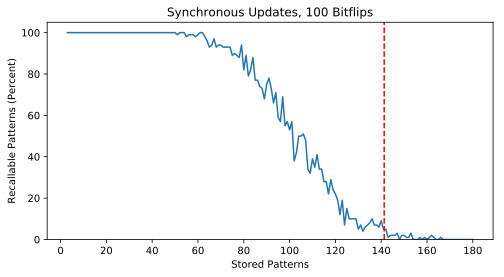

In [10]:
_, ax = subplots(1, 1, size=figsize(1, 2))

profile_capacity1(n=(3, 180), random=True, size=1024, ax=ax)

ax.axvline(0.138 * 1024, color='r', linestyle='--')

ax.set_ylim([0, 105])

plt.savefig('../figures/safe_storage_random.svg')

# Profile Pattern Stability

In [4]:
def profile_capacity2(n,
                      patterns=None,
                      random=False,
                      size=None,
                      noise=0,
                      bias=0,
                      remove_self_connections=False,
                      show_reference=False,
                      show_maximum=False,
                      ax=None):

    if ax is None:
        _, ax = subplots(1, 1, size=figsize(1, 2))

    if isinstance(n, int):
        n = (1, n)

    if len(n) == 3:
        ns = range(n[0], n[1] + 1, n[2])
    else:
        ns = range(n[0], n[1] + 1)

    if random:
        if bias == 0:
            patterns = [
                np.random.choice([-1, 1], size=size).astype(np.int8)
                for _ in range(n[1] + 1)
            ]
        else:
            patterns = [
                np.sign(bias + np.random.randn(size))
                for _ in range(n[1] + 1)
            ]
            
            for i in range(len(patterns)):
                patterns[i][patterns[i] == 0] = 1

    successes_async = []
    successes_sync = []

    for i, n_train in enumerate(ns):
        fmt = "{} patterns"
        sys.stdout.write(fmt.format(n_train).ljust(80) + "\r")
        sys.stdout.flush()

        model = HopfieldNetwork()

        model.train(patterns[:n_train],
                    synchronous=True,
                    check=False)
        
        if remove_self_connections:
            i, j = np.indices(model.weights.shape)
            model.weights[i == j] = 0

        success_async = 0
        success_sync = 0

        for pattern in patterns[:n_train]:
            pattern_noisy = add_noise(pattern, noise)

            # check stability for sync. updates
            pattern_ = pattern_noisy
            for _ in range(len(pattern)):
                pattern_ = model.update(pattern_, synchronous=False)

            if np.array_equal(pattern_, pattern):
                success_async += 1

            # check stability for async. updates
            pattern_ = model.update(pattern_noisy, synchronous=True)

            if np.array_equal(pattern_, pattern):
                success_sync += 1

        successes_async.append(success_async)
        successes_sync.append(success_sync)

        if show_maximum:
            if successes_async[-1] == n_train:
                peak_async = n_train

            if successes_sync[-1] == n_train:
                peak_sync = n_train

    ax.plot(ns, successes_async, label="Simultaneous Updates")
    ax.plot(ns, successes_sync, label="Sequential Updates")

    if show_reference:
        ax.plot([1, ns[-1]], [1, ns[-1]], color='r', linestyle='--')

    if show_maximum:
        print("async. max. capacity at {}".format(peak_async))
        ax.axvline(peak_async, color='r', linestyle='--')

        print("sync. max. capacity at {}".format(peak_sync))
        ax.axvline(peak_sync, color='r', linestyle='--')

    ax.set_title("{} Bitflips".format(noise))

    ax.set_xlabel("Number of Training Patterns")
    ax.set_ylabel("Stable Patterns")

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_xlim([1, ns[-1]])

    ax.legend()
    ax.grid()

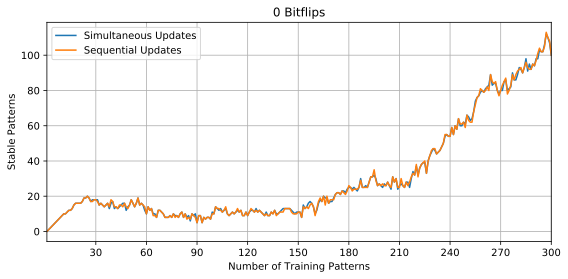

In [30]:
_, ax = subplots(1, 1, size=figsize(1, 2))

profile_capacity2(n=300, random=True, size=100, ax=ax)

plt.tight_layout()

plt.savefig('../figures/remaining_stable_no_noise.svg')

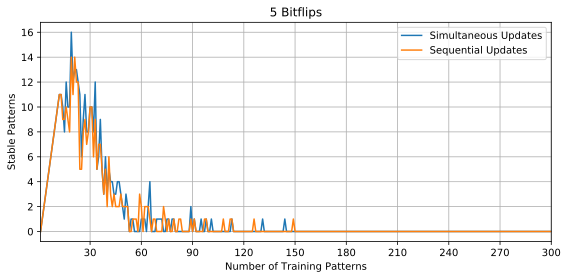

In [31]:
_, ax = subplots(1, 1, size=figsize(1, 2))

profile_capacity2(n=300, random=True, size=100, noise=5, ax=ax)

plt.tight_layout()

plt.savefig('../figures/remaining_stable_noise.svg')

async. max. capacity at 11                                                      
sync. max. capacity at 11


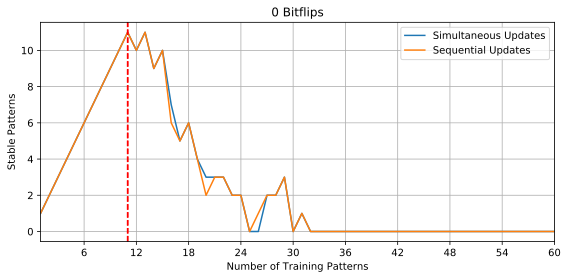

In [48]:
_, ax = subplots(1, 1, size=figsize(1, 2))

profile_capacity2(n=60,
                  random=True,
                  size=100,
                  remove_self_connections=True,
                  show_maximum=True,
                  ax=ax)

plt.tight_layout()

plt.savefig('../figures/remaining_stable_no_noise_no_self.svg')

async. max. capacity at 6                                                       
sync. max. capacity at 6


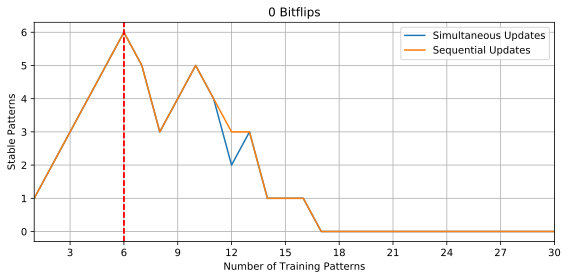

In [50]:
_, ax = subplots(1, 1, size=figsize(1, 2))

profile_capacity2(n=30,
                  random=True,
                  size=100,
                  bias=0.5,
                  remove_self_connections=True,
                  show_maximum=True,
                  ax=ax)

plt.tight_layout()

plt.savefig('../figures/remaining_stable_no_noise_no_self_bias.svg')